In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/mi_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2013-09-27,1.0
2013-12-06,1.0
2013-12-20,1.0
2014-01-14,1.0
2014-01-15,1.0
...,...
2020-01-20,45.0
2020-01-21,87.0
2020-01-22,79.0


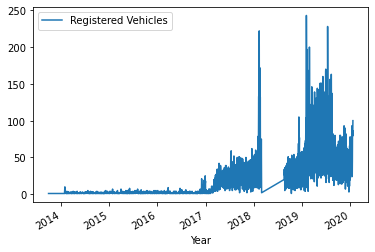

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

In [5]:
adtest = adfuller(df)
display(adtest)
# Not stationary - pvalue .58

(-1.4071188540453121,
 0.578858531953611,
 20,
 1663,
 {'1%': -3.434288317816291,
  '5%': -2.863279543282764,
  '10%': -2.5676960908695463},
 13949.832210435587)

In [6]:

# plt.plot(pd.Series(np.log(df), index = df['Year']), color = 'blue')

## **RESAMPLING

In [7]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [8]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

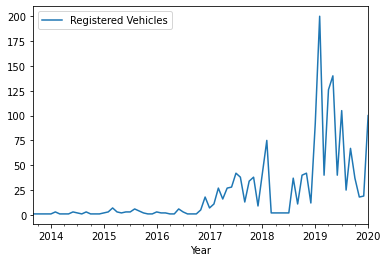

In [9]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

In [11]:
# data_transform = pd.Series(np.sqrt(df))

# rolmean = data_transform.rolling(window = 3).mean()
# fig = plt.figure(figsize = (11,7))
# orig = plt.plot(data_transform, color = 'blue', label = 'observed')
# mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
# plt.legend(loc='best')

## Testing 

## Modeling

In [12]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2019-05']
test = df['2019-06':]
combined = df
test

,Registered Vehicles
Year,
2019-06-30,40.0
2019-07-31,105.0
2019-08-31,25.0
2019-09-30,67.0
2019-10-31,37.0
2019-11-30,18.0
2019-12-31,19.0
2020-01-31,100.0


In [13]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=704.903, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=666.971, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=679.847, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=661.260, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=642.932, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=643.243, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=643.798, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=654.401, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=645.227, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=643.867, Time=0.11 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.684 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -3

### The best model is :  ARIMA (2, 0, 1) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9802      0.185      5.286      0.000       0.617       1.344
ar.L2          0.1326      0.205      0.648      0.517      -0.269       0.534
ma.L1         -0.6932      0.162     -4.281      0.000      -1.011      -0.376
sigma2       635.8606     53.810     11.817      0.000     530.395     741.326


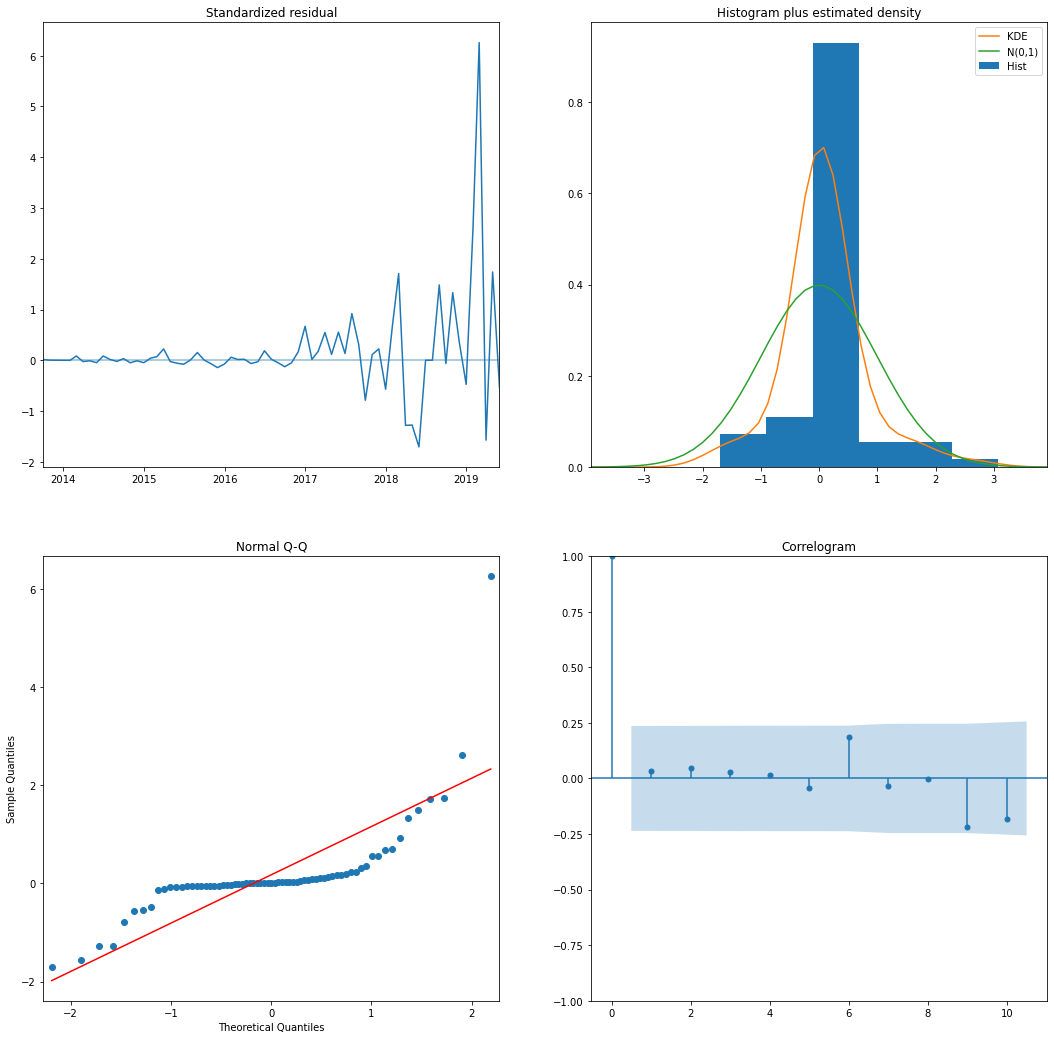

In [14]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [16]:
pred = output.get_prediction(start=pd.to_datetime('2019-06-02'), end=pd.to_datetime('2020-02-02'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2019-06-30,89.629350,188.475337
2019-07-31,103.435781,206.272096
2019-08-31,114.879601,225.553980
2019-09-30,127.845863,246.893578
2019-10-31,141.961735,270.476463
2019-11-30,157.410583,296.526588
2019-12-31,174.322946,325.287837
2020-01-31,192.851701,357.028331
2020-02-29,213.164322,392.042877


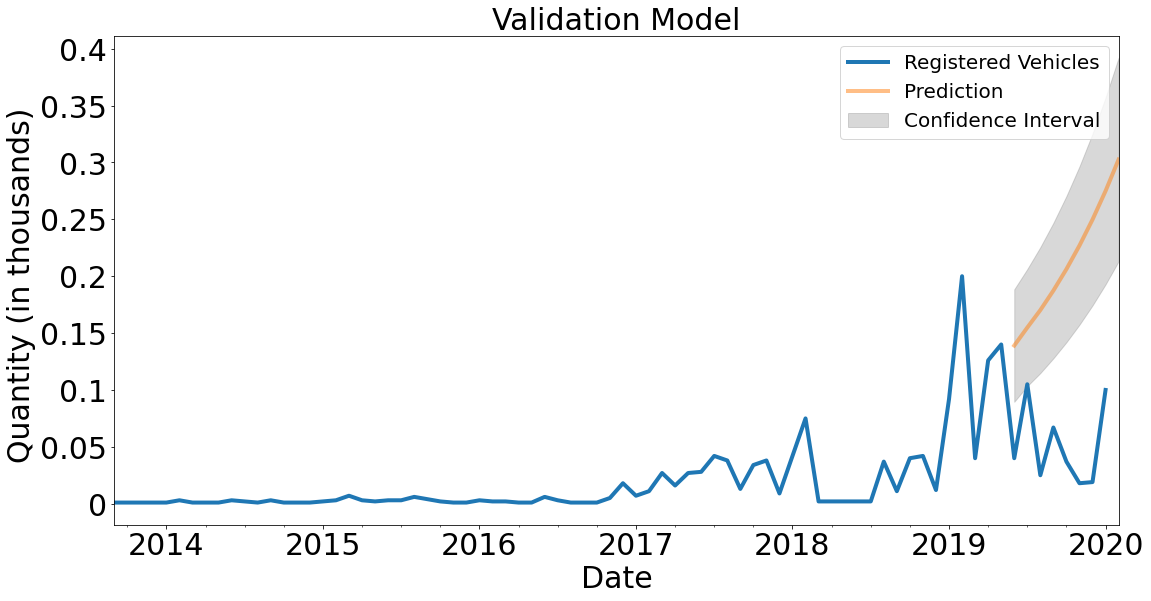

In [17]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [21]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9802      0.185      5.286      0.000       0.617       1.344
ar.L2          0.1326      0.205      0.648      0.517      -0.269       0.534
ma.L1         -0.6932      0.162     -4.281      0.000      -1.011      -0.376
sigma2       635.8606     53.810     11.817      0.000     530.395     741.326


In [22]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2020-02-29,2.196838,130.364778,66.280808
2020-03-31,-32.951004,120.813915,43.931456
2020-04-30,-52.756812,110.993060,29.118124
2020-05-31,-64.674688,103.274144,19.299728
2020-06-30,-72.088316,97.672348,12.792016
2020-07-31,-76.796620,93.753923,8.478651
2020-08-31,-79.828478,91.067916,5.619719
2020-09-30,-81.799260,89.248850,3.724795
2020-10-31,-83.088535,88.026184,2.468824
2020-11-30,-83.935630,87.208343,1.636357


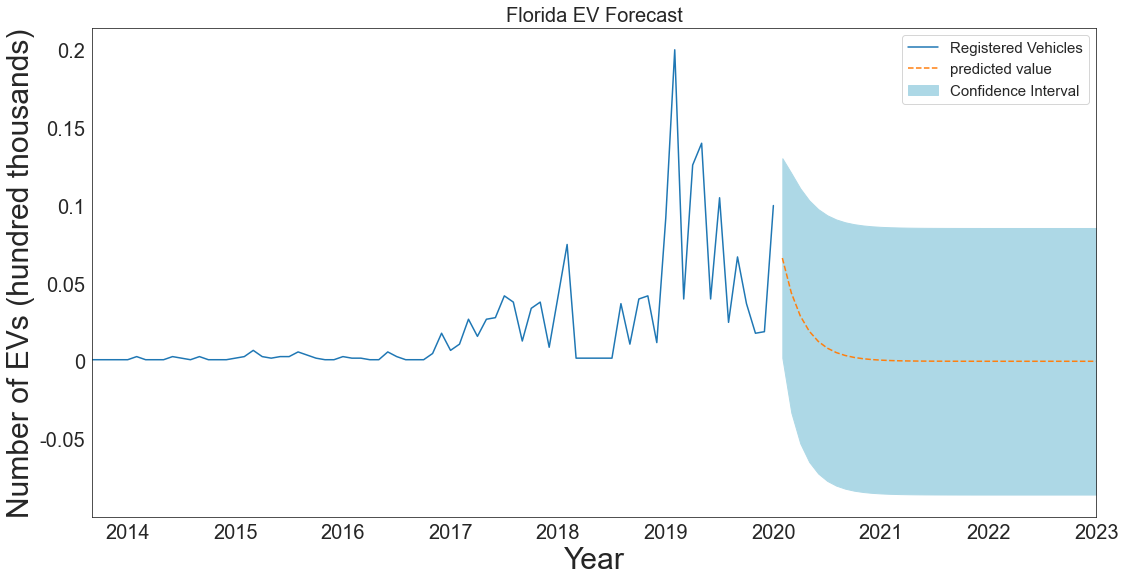

In [23]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida EV Forecast',fontsize=20)
plt.legend(fontsize = 15)
plt.show()